In [7]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration

gpus = list_physical_devices('GPU')
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=1200)])
print(len(gpus), "Physical GPUs")

def df_to_X_y(df, window_size=128):
    df_as_np = df.to_numpy()
    X,y = [], []
    for i in range(len(df_as_np)-window_size):
        if abs(df_as_np[i+window_size][0] - (window_size*(df_as_np[i-1][0]-df_as_np[i][0])+df_as_np[i][0])) < 1:
            X.append(df_as_np[i:i+window_size])
            y.append(df_as_np[i+window_size][-1])
    return np.array(X), np.array(y)

1 Physical GPUs


In [34]:
def training_LSTM(df, WINDOW_SIZE,n_LSTM,loss,metrics):
    X1, y1 = df_to_X_y(df, WINDOW_SIZE)
    X_train, y_train, X_test, y_test = X1[0:1500000,:,1:],y1[0:1500000],X1[1500000:,:,1:],y1[1500000:]
    model = Sequential()
    model.add(InputLayer((WINDOW_SIZE,4)))
    model.add(LSTM(n_LSTM))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.compile(loss=loss,
                   optimizer=Adam(learning_rate=0.01),
                   metrics=metrics)


    callback = [ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=True,
                                  min_lr=0.00001),
               ModelCheckpoint("models/LSTM_{}-{}-{}-{}.h5".format(WINDOW_SIZE,n_LSTM,loss.__class__.__name__,metrics.__class__.__name__), 
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True, 
                                 mode='min'),
               EarlyStopping(monitor='val_loss', patience=7),
               TensorBoard(log_dir="Tensor_logs")
               ]

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,callbacks=[callback])
    
    grbs = glob.glob("Data/A_grbs_jdxyzlog_firm3/*.csv")
    n_grbs = len(grbs)
    print(n_grbs)
    fig, axs = plt.subplots(n_grbs,4,figsize=(30,3*n_grbs))
    for n , grb in enumerate(grbs):
        df = pd.read_csv(grb)
        num_df = df.to_numpy()
        df = df.drop(['time'],axis=1)
        y_pred0 = []
        X0 = df[:WINDOW_SIZE].copy().to_numpy()
        for i in range(len(df)-WINDOW_SIZE):
            pred = model.predict(X0.reshape(1,WINDOW_SIZE,4))[0]
            y_pred0.append(pred)
            X0 = df[i+1:i+WINDOW_SIZE+1].copy().to_numpy()
            X0[:,-1] = pred
        true_lc = 10**(np.array(num_df[WINDOW_SIZE:,-1]))
        pred_lc = 10**(np.array(y_pred0).T[0])
        
        axs[n,0].hist(true_lc-pred_lc)
        
        axs[n,1].plot(true_lc)
        axs[n,1].plot(pred_lc)
        
        axs[n,2].plot(true_lc[-64:])
        axs[n,2].plot(pred_lc[-64:])
        
        axs[n,3].plot((true_lc-pred_lc)/true_lc)
    plt.show()
    plt.savefig('LSTM_{}-{}-{}-{}.png'.format(WINDOW_SIZE,n_LSTM,loss,metrics))
    
    
    

In [11]:
df = pd.read_csv("Data/A_jdxyzlog_firm3.csv") # data (hopefuly without grbs)
df

,time,x,y,z,log_cps
0,481.489854,198.004559,-264.929213,-455.839536,1.981139
1,481.489901,226.530494,-367.147747,-361.979136,1.985651
2,481.489947,226.612597,-453.022604,-246.006367,1.984527
3,481.489993,202.300037,-512.695303,-115.236975,2.024280
4,481.490039,160.243127,-539.293648,22.453799,1.973128
...,...,...,...,...,...
1967242,716.451978,292.031434,25.065833,-446.488696,3.933892
1967243,716.451989,264.282458,17.898810,-463.809937,3.940467
1967244,716.452001,235.360313,11.688833,-479.350154,3.935809
1967245,716.452012,204.902403,6.686862,-493.253822,3.949341


In [ ]:
win = [64,128,256]
nn = [64,128,256]
losses = [MeanSquaredError(),MeanAbsoluteError()]
metrics = [MeanSquaredError(), RootMeanSquaredError(),MeanAbsoluteError()]
for window in win:
    for n in nn:
        for loss in losses:
            for metric in metrics:
                training_LSTM(df,window,n,loss,metric)

2023-04-05 10:49:08.177434: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-04-05 10:49:08.177460: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-04-05 10:49:08.177498: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-04-05 10:49:08.177510: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
   60/46875 [..............................] - ETA: 2:55 - loss: 2.7829 - mean_squared_error: 2.7829

2023-04-05 10:49:10.243031: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-04-05 10:49:10.243055: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-04-05 10:49:10.243095: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-04-05 10:49:10.275240: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-04-05 10:49:10.275962: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-04-05 10:49:10.276534: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-04-05 10:49:10.277088: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Tensor_logs/train/plugins/profile/2023_04_05_10_49

46875/46875 [==============================] - 146s 3ms/step - loss: 0.5420 - mean_squared_error: 0.5420 - val_loss: 0.6643 - val_mean_squared_error: 0.6643

Epoch 00001: val_loss improved from inf to 0.66428, saving model to models/LSTM_64-64-MeanSquaredError-MeanSquaredError.h5
Epoch 2/100
46875/46875 [==============================] - 145s 3ms/step - loss: 0.4994 - mean_squared_error: 0.4994 - val_loss: 0.6773 - val_mean_squared_error: 0.6774

Epoch 00002: val_loss did not improve from 0.66428
Epoch 3/100
46875/46875 [==============================] - 145s 3ms/step - loss: 0.4945 - mean_squared_error: 0.4945 - val_loss: 0.6677 - val_mean_squared_error: 0.6677

Epoch 00003: val_loss did not improve from 0.66428
Epoch 4/100
46875/46875 [==============================] - 145s 3ms/step - loss: 0.4939 - mean_squared_error: 0.4939 - val_loss: 0.6697 - val_mean_squared_error: 0.6698

Epoch 00004: val_loss did not improve from 0.66428
Epoch 5/100
46875/46875 [==============================]

In [30]:
# converts data into WINDOW_SIZE chunks
WINDOW_SIZE = 64
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

KeyboardInterrupt: 

In [4]:
X_train, y_train, X_test, y_test = X1[0:1500000,:,1:],y1[0:1500000],X1[1500000:,:,1:],y1[1500000:]

In [5]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE,4)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

2023-04-04 21:21:34.310788: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 21:21:34.311129: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-04 21:21:34.311276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 21:21:34.311508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 46

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17664     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________


In [6]:
model1.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.01),
               metrics=RootMeanSquaredError())


callback = [ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              verbose=True,
                              min_lr=0.00001),
           ModelCheckpoint("models/LSTM_{}-{}-{}.h5".format(datetime.datetime.now().day,datetime.datetime.now().month,datetime.datetime.now().hour), 
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True, 
                             mode='min'),
           EarlyStopping(monitor='val_loss', patience=7),
           TensorBoard(log_dir="Tensor_logs")
           ]

history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,callbacks=[callback])

2023-04-04 21:21:35.022493: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-04-04 21:21:35.022512: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-04-04 21:21:35.022530: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-04-04 21:21:35.023095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-04-04 21:21:35.123410: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-04-04 21:21:35.124033: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-04-04 21:21:35.709506: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1536000000 exceeds 10% of free system memory.
2023-04-04 21:21:36.424380: I 

Epoch 1/100


2023-04-04 21:21:37.103077: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-04 21:21:37.296367: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


   59/46875 [..............................] - ETA: 2:47 - loss: 2.7135 - root_mean_squared_error: 1.5858 

2023-04-04 21:21:38.117498: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-04-04 21:21:38.117522: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-04-04 21:21:38.118021: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-04-04 21:21:38.123167: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-04-04 21:21:38.123876: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-04-04 21:21:38.124343: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-04-04 21:21:38.125309: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Tensor_logs/train/plugins/profile/2023_04_

46875/46875 [==============================] - 146s 3ms/step - loss: 0.5390 - root_mean_squared_error: 0.7330 - val_loss: 0.6688 - val_root_mean_squared_error: 0.8178

Epoch 00001: val_loss improved from inf to 0.66883, saving model to models/LSTM_4-4-21.h5
Epoch 2/100
46875/46875 [==============================] - 145s 3ms/step - loss: 0.4993 - root_mean_squared_error: 0.7066 - val_loss: 0.6396 - val_root_mean_squared_error: 0.7997

Epoch 00002: val_loss improved from 0.66883 to 0.63960, saving model to models/LSTM_4-4-21.h5
Epoch 3/100
46875/46875 [==============================] - 144s 3ms/step - loss: 0.4886 - root_mean_squared_error: 0.6990 - val_loss: 0.6593 - val_root_mean_squared_error: 0.8120

Epoch 00003: val_loss did not improve from 0.63960
Epoch 4/100
46875/46875 [==============================] - 144s 3ms/step - loss: 0.4853 - root_mean_squared_error: 0.6967 - val_loss: 0.6493 - val_root_mean_squared_error: 0.8058

Epoch 00004: val_loss did not improve from 0.63960
Epoch 

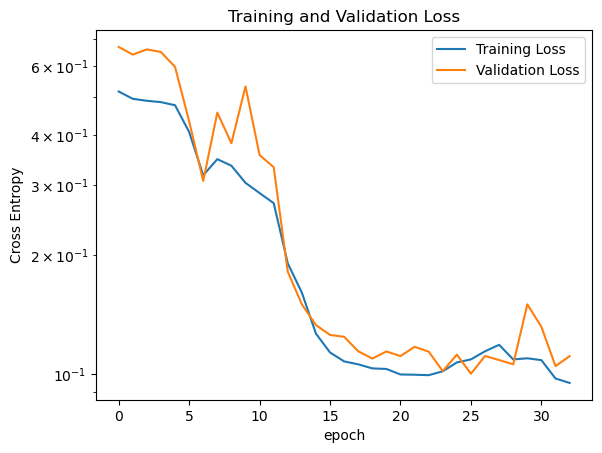

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

In [8]:
#model1.save('models/LSTM_newest.h5')

In [9]:
#model1 = load_model('models/LSTM_4var_win_128.h5')

In [10]:
plt.ioff()

35


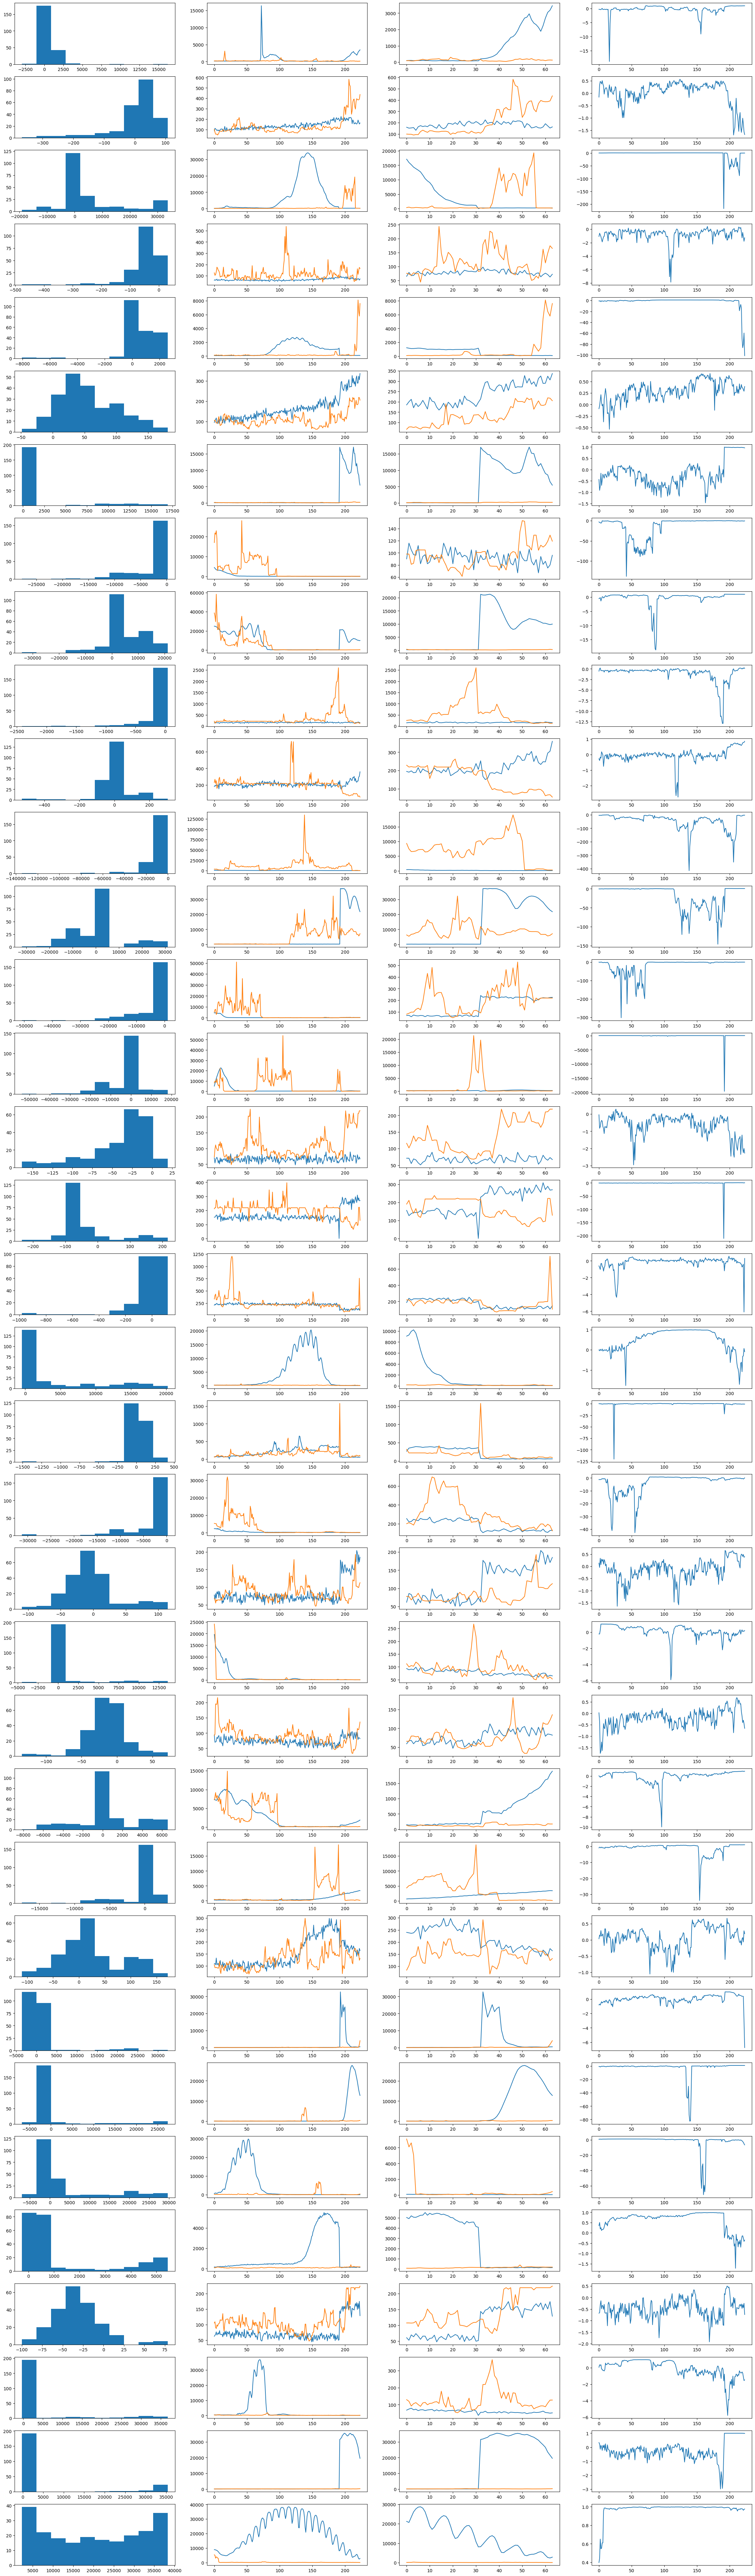

In [11]:
def is_LSTM_model_good(model,window_size=128):
    
    grbs = glob.glob("Data/A_grbs_jdxyzlog_firm3/*.csv")
    n_grbs = len(grbs)
    print(n_grbs)
    fig, axs = plt.subplots(n_grbs,4,figsize=(30,3*n_grbs))
    for n , grb in enumerate(grbs):
        df = pd.read_csv(grb)
        num_df = df.to_numpy()
        df = df.drop(['time'],axis=1)
        y_pred0 = []
        X0 = df[:window_size].copy().to_numpy()
        for i in range(len(df)-window_size):
            pred = model.predict(X0.reshape(1,window_size,4))[0]
            y_pred0.append(pred)
            X0 = df[i+1:i+window_size+1].copy().to_numpy()
            X0[:,-1] = pred
        true_lc = 10**(np.array(num_df[window_size:,-1]))
        pred_lc = 10**(np.array(y_pred0).T[0])
        
        axs[n,0].hist(true_lc-pred_lc)
        
        axs[n,1].plot(true_lc)
        axs[n,1].plot(pred_lc)
        
        axs[n,2].plot(true_lc[-64:])
        axs[n,2].plot(pred_lc[-64:])
        
        axs[n,3].plot((true_lc-pred_lc)/true_lc)
    plt.show()
    
    
    
is_LSTM_model_good(model1,WINDOW_SIZE)